<img src="../logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº8
#### Federico Borello

# Estimación Espectral de Potencia con Electrocardiograma

In [1]:
# @title: SetUp
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.io as sio


def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)


def calculate_psd_welch(signal_data, fs):
    # Seteo los "bins" del metodo welch a N/5, siendo N el largo de la señal.
    f, Pxx = signal.welch(signal_data, fs, nperseg=len(signal_data) // 5)
    Pxx_normalized = Pxx / np.sum(Pxx)
    return f, Pxx_normalized

# Seteo las Señales

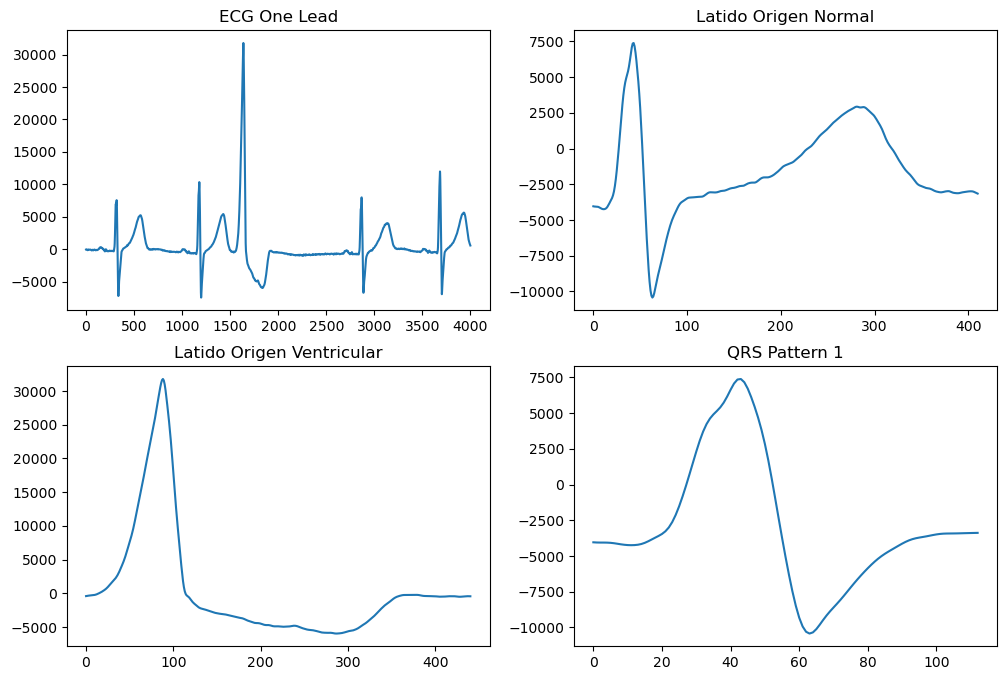

In [2]:
# Audio, ECG, PPG y Código original de la cátedra:
# https://github.com/marianux/pdstestbench/blob/4daeac9affd62217f4bafb8d7b8ec20834ba2a14/lectura_sigs.py

#######################################
# Lectura de Electrocardiograma (ECG) #
#######################################

# Información Util Sobre ECG:
# https://www.ncbi.nlm.nih.gov/books/NBK2214/

fs_ecg = 1000  # Hz

mat_struct = sio.loadmat("./ECG_TP4.mat")

ecg_one_lead = vertical_flaten(mat_struct["ecg_lead"])

# Latido normal
hb_1 = hb_n = vertical_flaten(mat_struct["heartbeat_pattern1"])
# Latido origen ventricular
hb_2 = hb_v = vertical_flaten(mat_struct["heartbeat_pattern2"])
# Complejo QRS normal
# https://en.wikipedia.org/wiki/QRS_complex
qrs_p1 = vertical_flaten(mat_struct["qrs_pattern1"])
# Vector de localización de los picos donde ocurren los latidos
qrs_d = vertical_flaten(mat_struct["qrs_detections"])

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(ecg_one_lead[24000:28000])
plt.title("ECG One Lead")

plt.subplot(2, 2, 2)
plt.plot(hb_1)
plt.title("Latido Origen Normal")

plt.subplot(2, 2, 3)
plt.plot(hb_2)
plt.title("Latido Origen Ventricular")

plt.subplot(2, 2, 4)
plt.plot(qrs_p1)
plt.title("QRS Pattern 1")

plt.show()

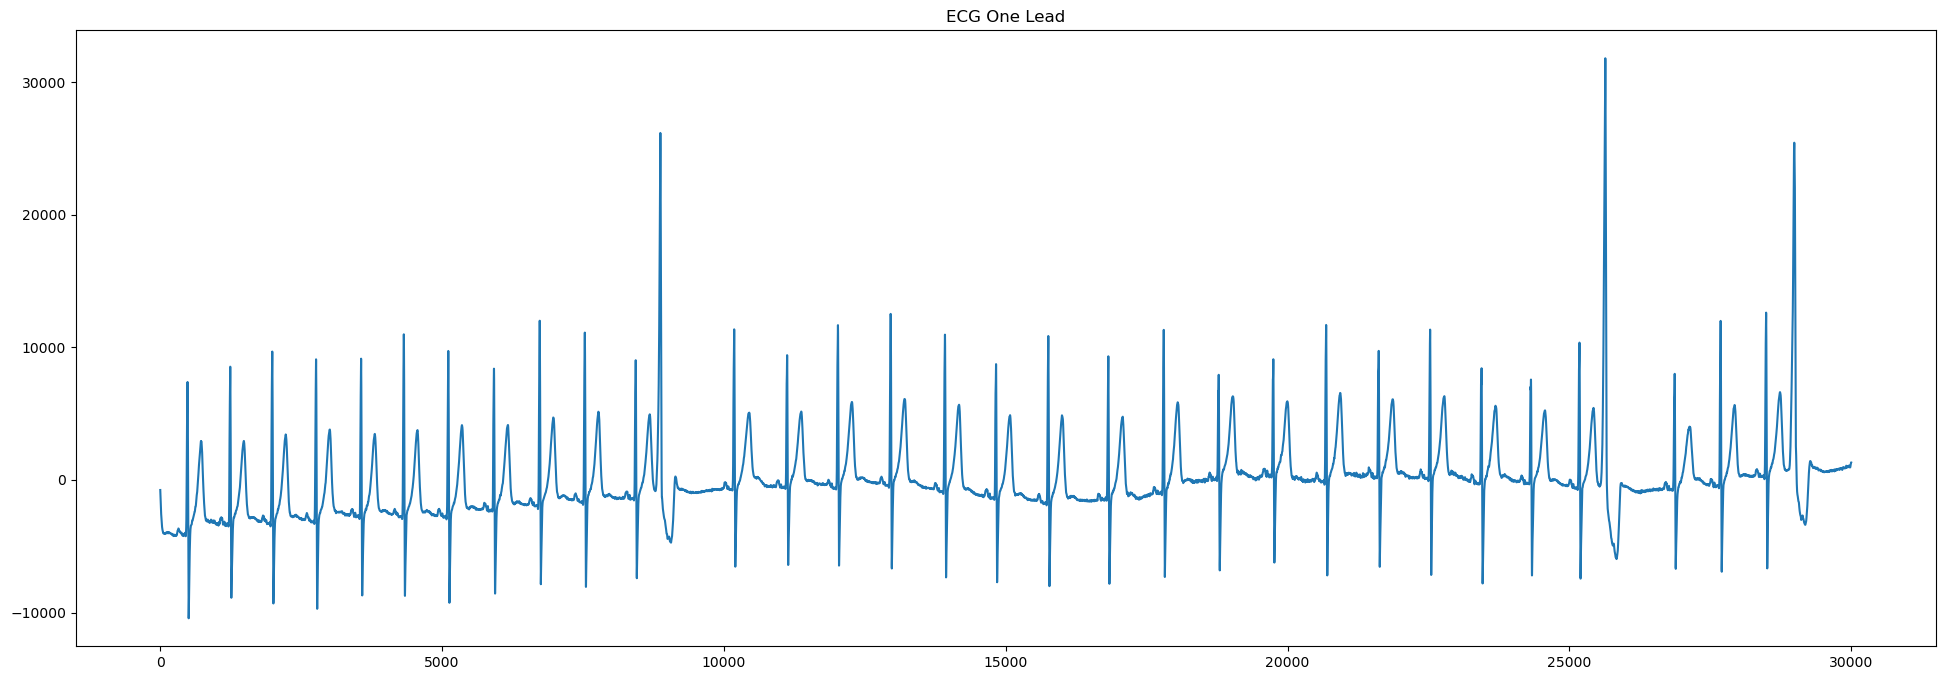

In [3]:
plt.figure(figsize=(24, 8))
plt.plot(ecg_one_lead[:30000])
plt.title("ECG One Lead")
plt.show()

# Cálculo de la Estimación Espectral de Potencia - Total de la Señal

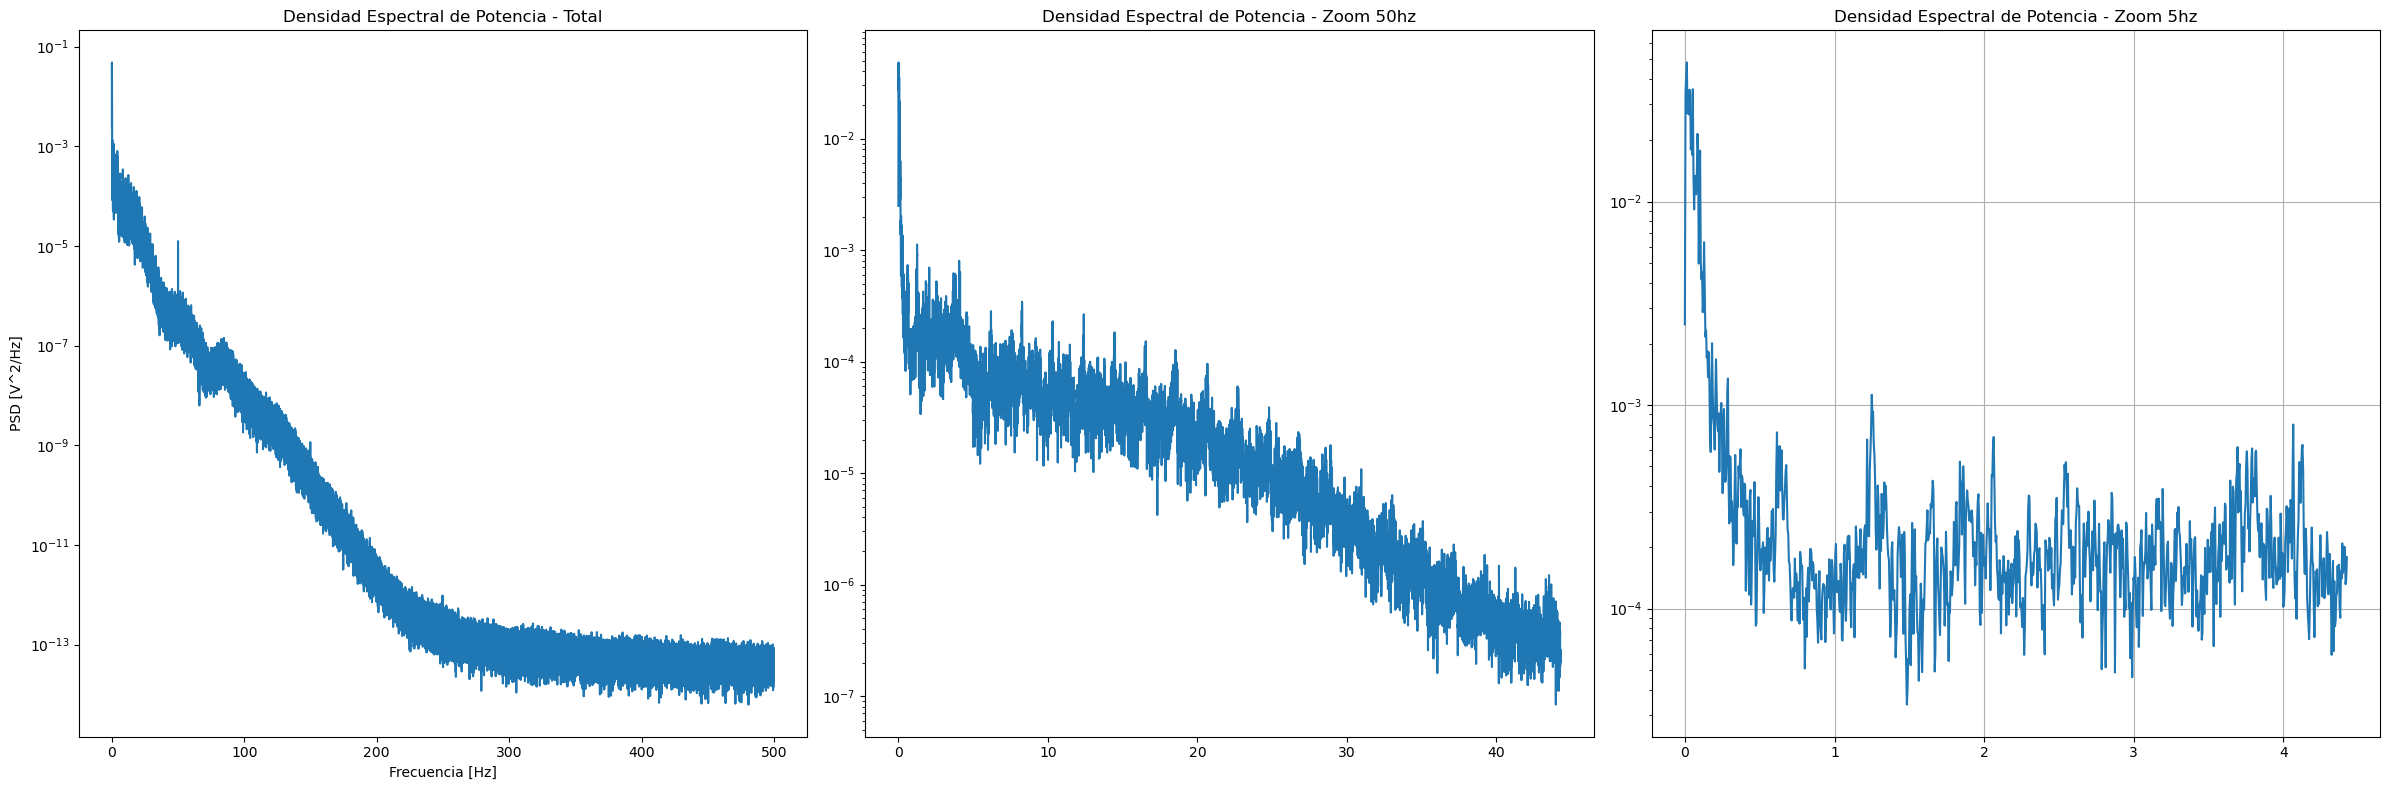

In [4]:
f_total, Pxx_ecg_total = calculate_psd_welch(ecg_one_lead.flatten(), fs_ecg)

plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.semilogy(f_total, Pxx_ecg_total)
plt.title("Densidad Espectral de Potencia - Total")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [V^2/Hz]")

plt.subplot(1, 3, 2)
plt.title("Densidad Espectral de Potencia - Zoom 50hz")
plt.semilogy(f_total[:10000], Pxx_ecg_total[:10000])

plt.subplot(1, 3, 3)
plt.title("Densidad Espectral de Potencia - Zoom 5hz")
plt.semilogy(f_total[:1000], Pxx_ecg_total[:1000])

plt.grid()
plt.tight_layout()
plt.show()

# Cálculo de la Estimación Espectral de Potencia - 10s

Se realiza la estimación de Potencia utilizando los primeros 10 segundos de la señal.
Y se grafica la PSD de un látido normal, otro ventricular y el complejo QRS.

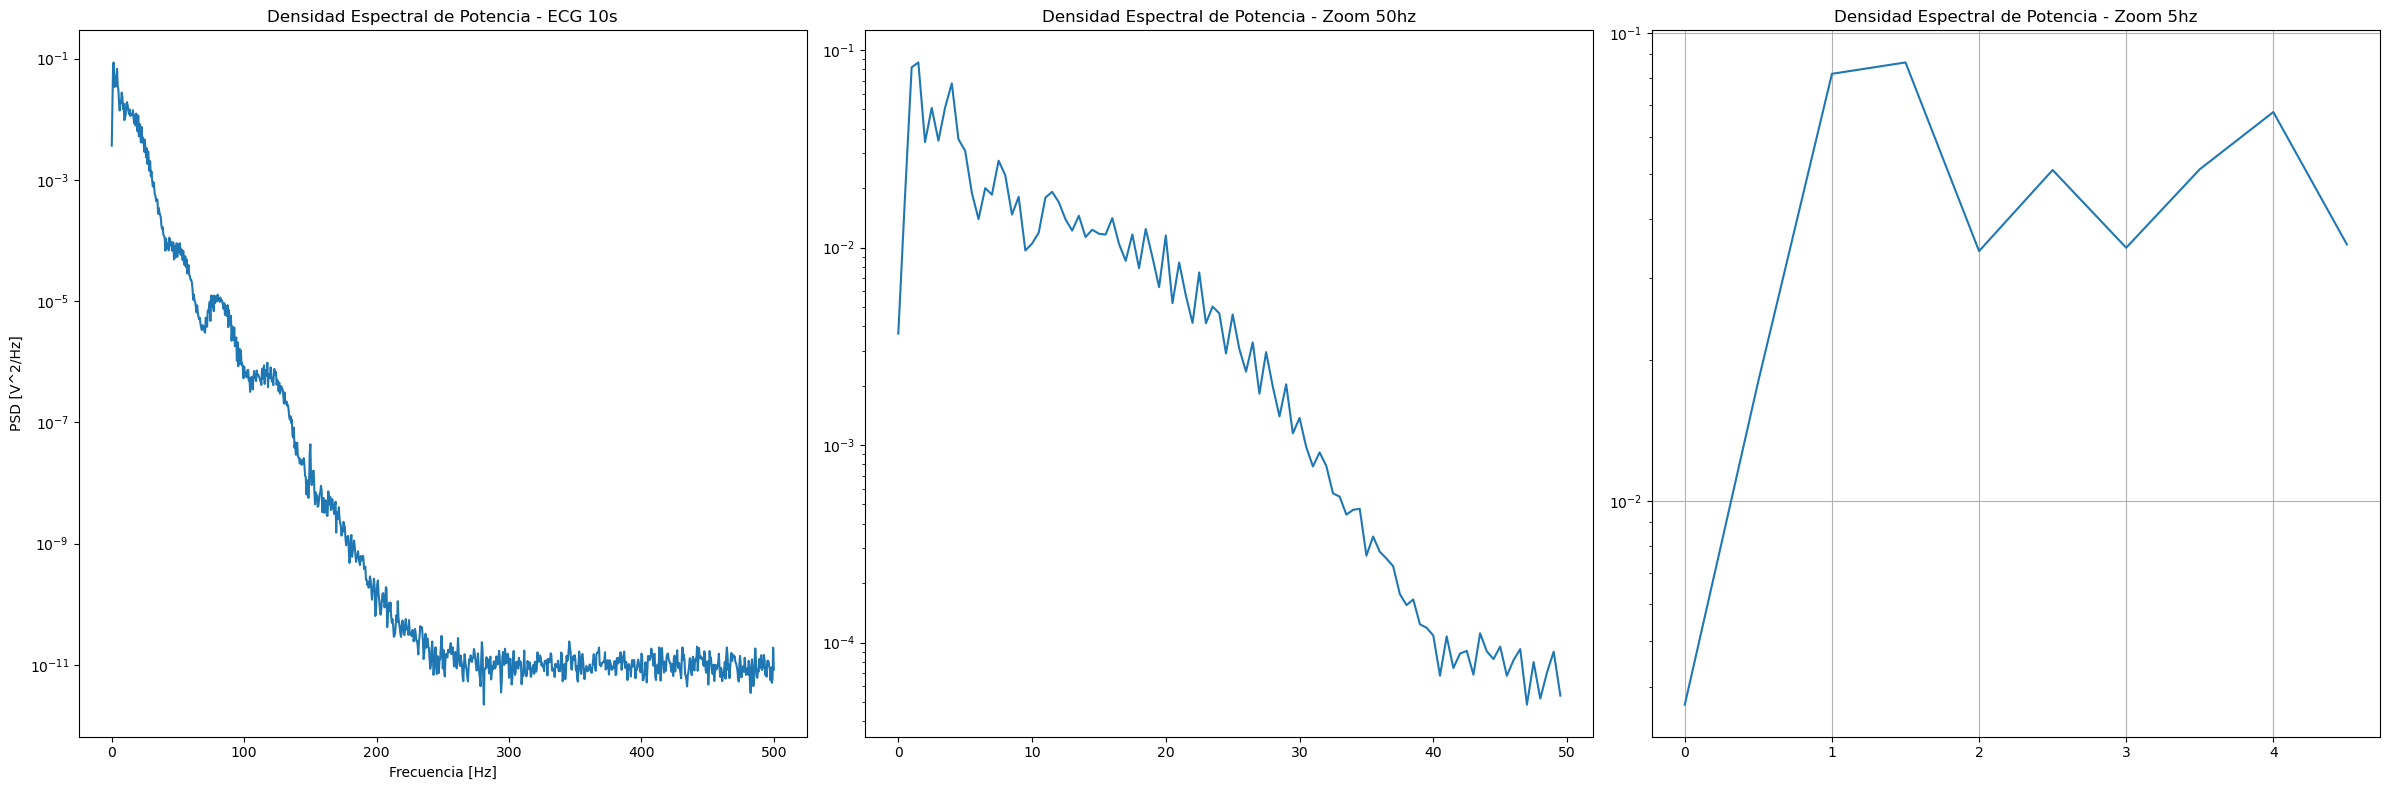

In [5]:
plt.figure(figsize=(24, 8))

f, Pxx_ecg_10s = calculate_psd_welch(ecg_one_lead[:10000].flatten(), fs_ecg)
plt.subplot(1, 3, 1)
plt.semilogy(f, Pxx_ecg_10s)
plt.title("Densidad Espectral de Potencia - ECG 10s")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [V^2/Hz]")

plt.subplot(1, 3, 2)
plt.title("Densidad Espectral de Potencia - Zoom 50hz")
plt.semilogy(f[:100], Pxx_ecg_10s[:100])

plt.subplot(1, 3, 3)
plt.title("Densidad Espectral de Potencia - Zoom 5hz")
plt.semilogy(f[:10], Pxx_ecg_10s[:10])

plt.grid()
plt.tight_layout()
plt.show()

# Cálculo de la Estimación Espectral de Potencia - ventanas específicas

La PSD de todas las realizaciones de latidos en una ventana que va desde ($R_i$ - 250 ms ; $R_i$ + 350 ms) para los i-ésimos latidos.

In [ ]:
# Función para calcular la PSD en ventanas alrededor de los picos QRS
def calculate_windowed_ecg_psd_welch(ecg_data, fs, qrs_d):
    all_Pxx = []
    f = fs
    for r in qrs_d:
        if r < 250 or r > (len(ecg_data) - 350):
            continue
        window = ecg_data[int(r - 250) : int(r + 350)]
        f, Pxx = calculate_psd_welch(window, fs)
        all_Pxx.append(Pxx)

    # Promedio de todas las PSDs
    if len(all_Pxx) == 0:
        avg_Pxx = 0
    else:
        avg_Pxx = np.mean(all_Pxx, axis=0)
    return f, all_Pxx, avg_Pxx


f_ecg_one_lead_n, all_Pxx_ecg_one_lead, avg_Pxx_ecg_one_lead = (
    calculate_windowed_ecg_psd_welch(ecg_one_lead.flatten(), fs_ecg, qrs_d)
)
for Pxx in all_Pxx_ecg_one_lead:
    plt.semilogy(f_ecg_one_lead_n, Pxx, "b")
plt.title("Densidad Espectral de Potencia - Por Latido")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [V^2/Hz]")
plt.grid()

# Ploteo de la PSD promedio
plt.semilogy(f_ecg_one_lead_n, avg_Pxx_ecg_one_lead, "r", label="Promedio")
plt.legend()
plt.tight_layout()
plt.show()

# Defina la plantilla del filtro

- fs0 = ?? # fin de la banda de detenida 0
- fc0 = ?? # comienzo de la banda de paso
- fc1 = ?? # fin de la banda de paso
- fs1 = ?? # comienzo de la banda de detenida 1

In [7]:
# Calculo del Fin de la Banda de Paso

import sys
import os

sys.path.append(os.path.abspath(".."))
from pds_utils import bandwith

# Se calcula la frecuencia hasta la cual se encuentra el 99%
# de la energía del espectrodel promedio de todos los latidos
bw = bandwith.calculate_bandwidth(f_ecg_one_lead_n, avg_Pxx_ecg_one_lead, 0.99)

print(bw)

# Se calcula la frecuencia inferior de la banda de paso
# Se toma el umbral de -3dB
# Se busca el primer valor que supera el umbral, se multiplica por 1/sqrt(2) == 0.7
# ya que -3dB es 0.7 veces el valor máximo

threshold = 1 / np.sqrt(2) * np.max(Pxx)  # Umbral -3 dB
lower_limit = f[np.where(Pxx >= threshold)[0][0]]

print(f"Lower Limit: {lower_limit} Hz")

Ancho de Banda: 41.67 Hz
Límite Inferior: 0.00 Hz
Límite Superior: 41.67 Hz
Lower Limit: 0.5 Hz


Con este cálculo, que es el mismo realizado en la TS7 (ahora se utiliza desde un módulo), se observa que podemos utilizar un valor de $40 \, [Hz]$ como fin de la banda de paso para obtener una frecuencia redondeada.

Se nota que el límite inferior calculado es $0 \, [Hz]$, debido a la forma en que se calcula el ancho de banda. Para obtener el valor inferior, utilizamos el criterio de los $-3 \, [dB]$, lo que resulta en $0.5 \, [Hz]$.

A continuación, se aplica el método Welch a la totalidad de los latidos registrados, con la particularidad de que se aplicará un `detrend` para eliminar el ruido y las frecuencias bajas. Además, se utilizará la longitud de la señal como la cantidad de ventanas.


Ancho de Banda: 38.33 Hz
Límite Inferior: 1.67 Hz
Límite Superior: 40.00 Hz
Lower Limit: 0.5 Hz


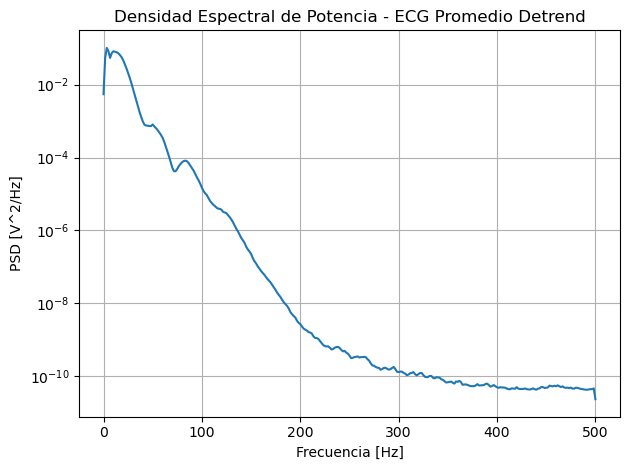

In [17]:
# Función para calcular la PSD en ventanas alrededor de los picos QRS
def calculate_windowed_ecg_psd_welch(ecg_data, fs, qrs_d):
    all_Pxx = []
    f = fs
    for r in qrs_d:
        if r < 250 or r > (len(ecg_data) - 350):
            continue
        window = ecg_data[int(r - 250) : int(r + 350)]
        # Aplicamos detrend a la señal para eliminar la componente continua o el ruido de baja frecuencia
        f, Pxx = signal.welch(window, fs, nperseg=len(window), detrend="linear")
        Pxx = Pxx / np.sum(Pxx)
        all_Pxx.append(Pxx)

    # Promedio de todas las PSDs
    if len(all_Pxx) == 0:
        avg_Pxx = 0
    else:
        avg_Pxx = np.mean(all_Pxx, axis=0)
    return f, all_Pxx, avg_Pxx


f_avg_detrend, all_Pxx_detrend, avg_Pxx_detrend = calculate_windowed_ecg_psd_welch(
    ecg_one_lead.flatten(), fs_ecg, qrs_d
)


bw = bandwith.calculate_bandwidth(f_avg_detrend, avg_Pxx_detrend, 0.99)

print(bw)

threshold = 1 / np.sqrt(2) * np.max(Pxx)  # Umbral -3 dB
lower_limit = f[np.where(Pxx >= threshold)[0][0]]

print(f"Lower Limit: {lower_limit} Hz")

plt.semilogy(f_avg_detrend, avg_Pxx_detrend)
plt.title("Densidad Espectral de Potencia - ECG Promedio Detrend")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [V^2/Hz]")
plt.grid()
plt.tight_layout()
plt.show()

El `detrend` parece no influir al promediar mucha cantidad de señales/latidos, utilizar el largo de la señal como la cantidad de ventanas del metodo welch genera la principal diferencia.

Se observa que el criterio de los $-3 \, [dB]$ nos proporciona un límite inferior de $0.5 \, [Hz]$. Sin embargo, al calcular el ancho de banda, obtenemos un límite inferior de $1.67 \, [Hz]$. Por lo tanto, se propone utilizar un valor de $1 \, [Hz]$ como comienzo de la banda de paso.

Finalmente, para las bandas de corte o bandas detenidas inferior y superior, se sugiere utilizar $0.5 \, [Hz]$ como banda detenida inferior y $41 \, [Hz]$ como banda detenida superior para dejar un margen adecuado.

La plantilla del filtro quedaría de la siguiente forma:
- fs0 = $0.5 \, [Hz]$
- fc0 = $1 \, [Hz]$
- fc1 = $40 \, [Hz]$
- fs1 = $41 \, [Hz]$
